# Numerical implementation in dolfinx

Import required libraries

In [2]:
import dolfinx, ufl
import numpy as np
import sympy as sp
from mpi4py import MPI
from petsc4py import PETSc
from matplotlib import pyplot as plt
import sys
from pathlib import Path
sys.path.append("../utils/")
from evaluate_on_points import evaluate_on_points
#import mesh_plotter
from petsc_problems import SNESProblem

import pyvista

def plot_damage_state(state, load=None):
    """
    Plot the displacement and damage field with pyvista
    """
    u = state["u"]
    alpha = state["alpha"]

    mesh = u.function_space.mesh

    plotter = pyvista.Plotter(
        title="Damage state", window_size=[800, 300], shape=(1, 2)
    )

    topology, cell_types, x = dolfinx.plot.create_vtk_mesh(u.function_space.mesh)
    grid = pyvista.UnstructuredGrid(topology, cell_types, x)
    
    plotter.subplot(0, 0)
    if load is not None:
        plotter.add_text(f"Displacement - load {load:3.3f}", font_size=11)
    else:
        plotter.add_text("Displacement", font_size=11)
    vals = np.zeros((x.shape[0], 3))
    vals[:,:len(u)] = u.x.array.reshape((x.shape[0], len(u)))
    grid["u"] = vals
    warped = grid.warp_by_vector("u", factor=0.1)
    actor_1 = plotter.add_mesh(warped, show_edges=False)
    plotter.view_xy()

    plotter.subplot(0, 1)
    if load is not None:
        plotter.add_text(f"Damage - load {load:3.3f}", font_size=11)
    else:
        plotter.add_text("Damage", font_size=11)

    grid.point_data["alpha"] = alpha.x.array
    grid.set_active_scalars("alpha")
    plotter.add_mesh(grid, show_edges=False, show_scalar_bar=True, clim=[0, 1])
    plotter.view_xy()
    if not pyvista.OFF_SCREEN:
       plotter.show()

Input parameters

In [3]:

# Characteristic dimensions of the domain
geometry_parameters = {'Lx': 1., 
                       'Ly': 0.1}

# Regularization length               
material_properties = {'E': 1.0, 
                       'nu': 0.0, 
                       'rho': 1.,
                       'ell': 0.05,
                       'w_1': 1.0/2.0, # to have sigma_c = esp_c = 1
                       "c": 1.0  }

# Time stepping control
timestepping_parameters = {'initial_time':0.0, 
                           'total_time': 1.5, 
                           'delta_t': 1.e-3,
                           #'ramp_time': 5.0,
                           'rate': 1.0,
                           'beta': 0.25,
                           'gamma': 0.5}


parameters = {"geometry": geometry_parameters,
              "material": material_properties,
              "timestepping": timestepping_parameters,
              }

comm = MPI.COMM_WORLD

U_t = timestepping_parameters["rate"]

t_sp = sp.Symbol('t', real = True)
U_imp = sp.Piecewise((t_sp * U_t,True)) 

outdir = f'output/ell-{material_properties["ell"]:2.3f}'
if comm.rank == 0:
    Path(outdir).mkdir(parents=True, exist_ok=True)
    

In [4]:
U_imp = t_sp * U_t
V_imp = sp.diff(U_imp, t_sp)
A_imp = sp.diff(V_imp, t_sp)

Function spaces, functions and system's state

In [5]:
def mesh_bar(Lx, Ly, lc, order=1, comm=MPI.COMM_WORLD):
    """
    Create mesh of 3d tensile test specimen according to ISO 6892-1:2019 using the Python API of Gmsh.
    """
    # Perform Gmsh work only on rank = 0
    gdim = 2
    model_rank = 0
    if comm.rank == model_rank :
        import gmsh

        # Initialise gmsh and set options
        gmsh.initialize()
        gmsh.option.setNumber("General.Terminal", 1)

        # gmsh.option.setNumber("Mesh.Algorithm", 6)

        gmsh.option.setNumber("Mesh.Algorithm", 5)
        gmsh.model.mesh.optimize("Netgen")
        model = gmsh.model()
        model.add("Rectangle")
        model.setCurrent("Rectangle")
        p0 = model.geo.addPoint(-Lx/2, -Ly/2, 0, lc, tag=0)
        p1 = model.geo.addPoint(Lx/2, -Ly/2, 0, lc, tag=1)
        p2 = model.geo.addPoint(Lx/2, Ly/2, 0.0, lc, tag=2)
        p3 = model.geo.addPoint(-Lx/2, Ly/2, 0, lc, tag=3)
        # points = [p0, p1, p2, p3]
        bottom = model.geo.addLine(p0, p1)
        right = model.geo.addLine(p1, p2)
        top = model.geo.addLine(p2, p3)
        left = model.geo.addLine(p3, p0)
        cloop1 = model.geo.addCurveLoop([bottom, right, top, left])
        # surface_1 =
        model.geo.addPlaneSurface([cloop1])

        model.geo.synchronize()
        surface_entities = [model[1] for model in model.getEntities(gdim)]
        model.addPhysicalGroup(gdim, surface_entities, tag=5)
        model.setPhysicalName(gdim, 5, "Rectangle surface")

        # Set geometric order of mesh cells
        gmsh.option.setNumber("Mesh.Algorithm", 5)
        gmsh.option.setNumber("General.Verbosity", 1)
        model.mesh.setOrder(1)
        model.mesh.optimize("Netgen")
        model.mesh.generate(gdim)

    
    mesh, _, _ = gmshio.model_to_mesh(model, comm, model_rank,gdim=gdim)
    gmsh.finalize()

    return mesh


from dolfinx.io import gmshio
Lx = geometry_parameters['Lx']
Ly = geometry_parameters['Ly']
mesh = mesh_bar(Lx,Ly,material_properties["ell"]/4.0)

import pyvista
pyvista.start_xvfb(0.1)
topology, cell_types, x = dolfinx.plot.create_vtk_mesh(mesh)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.camera_position = 'xy'
plotter.save_graphic(f'{outdir}/mesh.pdf')

Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 3.458e-06s, CPU 1e-06s)


In [6]:
element_u = ufl.VectorElement('CG', mesh.ufl_cell(), degree=1, dim=mesh.topology.dim)
V_u = dolfinx.fem.FunctionSpace(mesh, element_u)
u = dolfinx.fem.Function(V_u, name="Displacement")
u_new = dolfinx.fem.Function(V_u)
v = dolfinx.fem.Function(V_u, name="Velocity")
v_new = dolfinx.fem.Function(V_u)
a = dolfinx.fem.Function(V_u, name="Acceleration")
a_new = dolfinx.fem.Function(V_u)

element_alpha = ufl.FiniteElement('Lagrange',mesh.ufl_cell(),degree=1)
V_alpha = dolfinx.fem.FunctionSpace(mesh, element_alpha)

alpha = dolfinx.fem.Function(V_alpha, name="Damage")

state = {"u": u,"v": v,"a": a,"alpha": alpha}

alpha_lb = dolfinx.fem.Function(V_alpha, name="Lower bound")
alpha_ub = dolfinx.fem.Function(V_alpha, name="Upper bound")
alpha_ub.x.array[:] = 1
alpha_lb.x.array[:] = 0

ones_u = dolfinx.fem.Function(V_u)
ones_u.x.array[:] = 1.0


In [7]:
# Geometrical regions  
def top(x):
    return np.isclose(x[1], +geometry_parameters["Ly"]/2)
def bottom(x):
    return np.isclose(x[1], -geometry_parameters["Ly"]/2)
def right (x):
    return np.isclose(x[0], +geometry_parameters["Lx"]/2)
def left (x):
    return np.isclose(x[0], -geometry_parameters["Lx"]/2)

# Geometrical sets
gdim = mesh.topology.dim
fdim = gdim - 1 
top_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, top)
bottom_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, bottom)
right_facets = dolfinx.mesh.locate_entities(mesh, fdim, right)
left_facets = dolfinx.mesh.locate_entities(mesh, fdim, left)

tagged_facets = np.hstack([top_facets, bottom_facets, right_facets, left_facets])
tag_values = np.hstack([np.full_like(top_facets, 1), 
                        np.full_like(bottom_facets, 2),
                        np.full_like(right_facets, 3),
                        np.full_like(left_facets, 4)])
tagged_facets_sorted = np.argsort(tagged_facets)

mt = dolfinx.mesh.meshtags(mesh, mesh.topology.dim-1, 
                           tagged_facets[tagged_facets_sorted], 
                           tag_values[tagged_facets_sorted])

# Domain and subdomain measures
dx  = ufl.Measure("dx", domain=mesh)                         # Domain measure
ds  = ufl.Measure("ds", domain=mesh, subdomain_data=mt)      # External Boundary measure
dS  = ufl.Measure("dS", domain=mesh, subdomain_data=mt)      # External/Internal measure
n   = ufl.FacetNormal(mesh)                                  # External normal to the boundary

left_boundary_dofs_ux = dolfinx.fem.locate_dofs_topological(V_u.sub(0), fdim, left_facets)
right_boundary_dofs_ux = dolfinx.fem.locate_dofs_topological(V_u.sub(0), fdim, right_facets)

# Clamped left (ux=uy=0) 
blocked_dofs_left_u = dolfinx.fem.locate_dofs_topological(V_u, fdim, left_facets)
bc_ux_left = dolfinx.fem.dirichletbc(PETSc.ScalarType(0), left_boundary_dofs_ux, V_u.sub(0))
bc_vx_left = dolfinx.fem.dirichletbc(PETSc.ScalarType(0), left_boundary_dofs_ux, V_u.sub(0))
bc_ax_left = dolfinx.fem.dirichletbc(PETSc.ScalarType(0), left_boundary_dofs_ux, V_u.sub(0))

# Imposed displacement right (ux=U_imp(t))
right_ux = dolfinx.fem.Constant(mesh,PETSc.ScalarType(0))
right_vx = dolfinx.fem.Constant(mesh,PETSc.ScalarType(0))
right_ax = dolfinx.fem.Constant(mesh,PETSc.ScalarType(0))
bc_ux_right = dolfinx.fem.dirichletbc(right_ux, right_boundary_dofs_ux, V_u.sub(0))
bc_vx_right = dolfinx.fem.dirichletbc(right_vx, right_boundary_dofs_ux, V_u.sub(0))
bc_ax_right = dolfinx.fem.dirichletbc(right_ax, right_boundary_dofs_ux, V_u.sub(0))

blocked_dofs_left_alpha = dolfinx.fem.locate_dofs_topological(V_alpha, fdim, left_facets)
blocked_dofs_right_alpha = dolfinx.fem.locate_dofs_topological(V_alpha, fdim, right_facets)
bc_alpha_left = dolfinx.fem.dirichletbc(PETSc.ScalarType(0.0), blocked_dofs_left_alpha, V_alpha)
bc_alpha_right = dolfinx.fem.dirichletbc(PETSc.ScalarType(0.0), blocked_dofs_right_alpha, V_alpha)

# Collect the BCs
bcs_u = [bc_ux_left, bc_ux_right]
bcs_v = [bc_vx_left, bc_ux_right]
bcs_a = [bc_ax_left, bc_ax_right]
bcs_alpha = [bc_alpha_left, bc_alpha_right]

Variational magnitudes

In [8]:

E_0   = dolfinx.fem.Constant(mesh, material_properties["E"])
nu_0  = dolfinx.fem.Constant(mesh, material_properties["nu"])
w_1 = dolfinx.fem.Constant(mesh, material_properties["w_1"])
ell = dolfinx.fem.Constant(mesh, material_properties["ell"])
rho = dolfinx.fem.Constant(mesh, material_properties["rho"])
c_diss = dolfinx.fem.Constant(mesh, material_properties["c"]) 

def w(alpha):
    """Dissipated energy function as a function of the damage """
    return 1 - (1-alpha) ** 2 

def aa(alpha, k_ell=0.0, b=4):
    """Stiffness modulation as a function of the damage """
    #return (1 - alpha) ** 2 + k_ell
    return (1-w(alpha))/(1+(b-1)*w(alpha))

def eps(u):
    """Strain tensor as a function of the displacement"""
    return ufl.sym(ufl.grad(u))

def sigma_0(eps):
    """Stress tensor of the undamaged material as a function of the displacement"""
    mu    = E_0 / (2.0 * (1.0 + nu_0))
    lmbda = E_0 * nu_0 / (1.0 - nu_0 ** 2)
    return 2.0 * mu * eps + lmbda * ufl.tr(eps) * ufl.Identity(gdim)

def sigma(eps,alpha):
    """Stress tensor of the damaged material as a function of the displacement and the damage"""
    return aa(alpha) * sigma_0(eps)

sigma_c = (E_0 * w_1) 
G_c = np.pi * w_1 * ell 
print(f'sigma_c = {float(sigma_c):2.3f}, G_c = {float(G_c):2.3f}')

# Body forces
b = dolfinx.fem.Constant(mesh, np.asarray([0.,0.]))

## Strain energy density (Linear elastic)
eps0_t = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0)) 
eps_0 = - eps0_t * ufl.Identity(gdim)
elastic_energy = 0.5 * ufl.inner(sigma(eps(u)-eps_0,alpha), eps(u)-eps_0) * dx 
dissipated_energy = w_1 * (w(alpha) + ell ** 2 * ufl.dot(ufl.grad(alpha), ufl.grad(alpha))) * dx
potential_energy = elastic_energy + dissipated_energy 


sigma_c = 0.500, G_c = 0.079


In [9]:
t = dolfinx.fem.Constant(mesh, 0.0)
delta_t_0 = timestepping_parameters['delta_t']
total_time =timestepping_parameters["total_time"]

beta = timestepping_parameters['beta']
gamma = timestepping_parameters['gamma']
delta_t = dolfinx.fem.Constant(mesh, delta_t_0)

def u_newmark(u,v,a,a_new,delta_t=delta_t,beta=beta):
    return u + delta_t * v + 0.5 * delta_t ** 2 * ((1 - 2 * beta) * a + 2 * beta * a_new)

def v_newmark(v,a,a_new,delta_t=delta_t,gamma=gamma):
    return (v + delta_t * ((1 - gamma) * a + gamma * a_new))

## Kinetic energy density
kinetic_energy_density = 0.5 * rho * ufl.inner(v,v)
kinetic_energy = kinetic_energy_density * dx
lagrangian = kinetic_energy - potential_energy
total_energy = kinetic_energy + potential_energy

dissipation_potential = 0.5 * c_diss * ufl.inner((v), (v)) * dx 

# Lagrangian derivatives
u_test = ufl.TestFunction(V_u)
potential_energy_du = ufl.derivative(potential_energy, u, u_test) 
kinetic_energy_dv = ufl.replace(ufl.derivative(kinetic_energy, v, u_test), {v: a})
dissipation_potential_dv = ufl.derivative(dissipation_potential, v, u_test)

# Newmark scheme
u_fd_scheme = u_newmark(u, v, a, a_new, delta_t=delta_t,beta=beta)
v_fd_scheme = v_newmark(v, a, a_new, delta_t=delta_t,gamma=beta)

# replace newmark scheme in the different terms
potential_energy_du_newmark = ufl.replace(potential_energy_du, {u: u_fd_scheme, v: v_fd_scheme, a: a_new})
dissipation_potential_dv_newmark = ufl.replace(dissipation_potential_dv,  {u: u_fd_scheme, v: v_fd_scheme, a: a_new})
kinetic_energy_dv_newmark = ufl.replace(kinetic_energy_dv,  {u: u_fd_scheme, v: v_fd_scheme, a: a_new})

# Residual u
alpha_test = ufl.TestFunction(V_alpha)
residual_u_newmark = kinetic_energy_dv_newmark + potential_energy_du_newmark + dissipation_potential_dv_newmark
jacobian_u_newmark = ufl.derivative(residual_u_newmark, a_new, ufl.TrialFunction(V_u)) 

# Residual u
residual_alpha_newmark = ufl.replace(ufl.derivative(potential_energy, alpha, alpha_test),{u: u_fd_scheme, v: v_fd_scheme})
jacobian_alpha_newmark = ufl.derivative(residual_alpha_newmark, alpha, ufl.TrialFunction(V_alpha))

Acceleration solver

In [10]:
# Displacement sub-problem
a_problem = SNESProblem(residual_u_newmark, a_new, bcs_a, J=jacobian_u_newmark)
b_vector = dolfinx.la.create_petsc_vector(V_u.dofmap.index_map, V_u.dofmap.index_map_bs)
J_matrix = dolfinx.fem.petsc.create_matrix(dolfinx.fem.form(a_problem.a))

# Acceleration Solver for the displacement problem
solver_a_snes = PETSc.SNES().create()
solver_a_snes.setType("ksponly")
solver_a_snes.setFunction(a_problem.F, b_vector)
solver_a_snes.setJacobian(a_problem.J, J_matrix)
solver_a_snes.setTolerances(rtol=1.0e-9, max_it=15)
solver_a_snes.getKSP().setType("preonly")
solver_a_snes.getKSP().setTolerances(rtol=1.0e-9)
solver_a_snes.getKSP().getPC().setType("lu")

# Damage sub-problem
damage_problem = SNESProblem(residual_alpha_newmark, alpha, bcs_alpha,J=jacobian_alpha_newmark)
b_alpha = dolfinx.la.create_petsc_vector(V_alpha.dofmap.index_map, V_alpha.dofmap.index_map_bs)
J_alpha = dolfinx.fem.petsc.create_matrix(damage_problem.a)

# Create damage SNESVI solver 
solver_alpha_snes = PETSc.SNES().create()
solver_alpha_snes.setType("vinewtonrsls")
solver_alpha_snes.setFunction(damage_problem.F, b_alpha)
solver_alpha_snes.setJacobian(damage_problem.J, J_alpha)
solver_alpha_snes.setTolerances(rtol=1.0e-9, max_it=50)
solver_alpha_snes.getKSP().setType("preonly")
solver_alpha_snes.getKSP().setTolerances(rtol=1.0e-9)
solver_alpha_snes.getKSP().getPC().setType("lu")
# We set the bound (Note: they are passed as reference and not as values)
solver_alpha_snes.setVariableBounds(alpha_lb.vector,alpha_ub.vector)

alt_min_parameters = {"atol": 1.e-6, "max_iter": 100}

def simple_monitor(state, iteration, error_L2):
    #if MPI.comm_world.rank == 0:
    print(f"         AM - Iteration: {iteration:3d}, Error: {error_L2:3.4e}")
    
def alternate_minimization(state,parameters=alt_min_parameters,monitor=None):
    
    u = state["u"]
    alpha = state["alpha"]
    
    alpha_old = dolfinx.fem.Function(alpha.function_space)
    
    
    for iteration in range(parameters["max_iter"]):
                              
        # solve displacement
        solver_a_snes.solve(None, a_new.vector)
        a_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        
        # solve damage
        alpha_old.x.array[:] = alpha.x.array
        solver_alpha_snes.solve(None, alpha.vector)
        alpha.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

        # check error and update
        L2_error = ufl.inner(alpha - alpha_old, alpha - alpha_old) * dx
        error_L2 = np.sqrt(dolfinx.fem.assemble_scalar(dolfinx.fem.form(L2_error)))

        if monitor is not None:
            monitor(state, iteration, error_L2)
                                 
        if error_L2 <= parameters["atol"]:
            break
    else:
        pass #raise RuntimeError(f"Could not converge after {iteration:3d} iteration, error {error_L2:3.4e}") 
    
    return (error_L2, iteration)


Magnitudes of interest

In [11]:
kinetic_energy_form = dolfinx.fem.form(kinetic_energy)
elastic_energy_form = dolfinx.fem.form(elastic_energy)
dissipated_energy_form = dolfinx.fem.form(dissipated_energy)
potential_energy_form = dolfinx.fem.form(potential_energy)
total_energy_form = dolfinx.fem.form(potential_energy + kinetic_energy)
reaction_force_right_form = dolfinx.fem.form(ufl.inner(n, sigma(eps(u)- eps_0,alpha) * n)*ds(3))

    

  plt.plot(points_loc[:, 0], u_values_loc[:,0]/max(u_values_loc[:,0]), "--", color="gray", linewidth = 2, label=r"$u$")



Solving for t = 0.00, load = 0.00, delta_t = 0.5000
         AM - Iteration:   0, Error: 0.0000e+00
Solving for t = 0.50, load = 0.05, delta_t = 0.5000
         AM - Iteration:   0, Error: 0.0000e+00
Solving for t = 1.00, load = 0.10, delta_t = 0.5000
         AM - Iteration:   0, Error: 0.0000e+00
Solving for t = 1.50, load = 0.15, delta_t = 0.5000
         AM - Iteration:   0, Error: 0.0000e+00
Solving for t = 2.00, load = 0.20, delta_t = 0.5000
         AM - Iteration:   0, Error: 0.0000e+00
Solving for t = 2.50, load = 0.25, delta_t = 0.5000
         AM - Iteration:   0, Error: 0.0000e+00
Solving for t = 3.00, load = 0.30, delta_t = 0.5000
         AM - Iteration:   0, Error: 0.0000e+00
Solving for t = 3.50, load = 0.35, delta_t = 0.5000
         AM - Iteration:   0, Error: 0.0000e+00
Solving for t = 4.00, load = 0.40, delta_t = 0.5000
         AM - Iteration:   0, Error: 0.0000e+00
Solving for t = 4.50, load = 0.45, delta_t = 0.0500
         AM - Iteration:   0, Error: 0.0000e+00



Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(



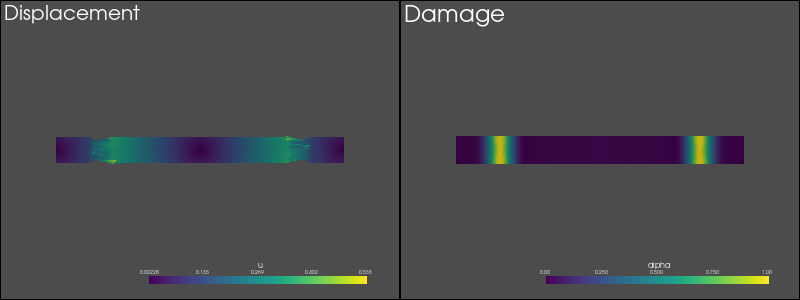

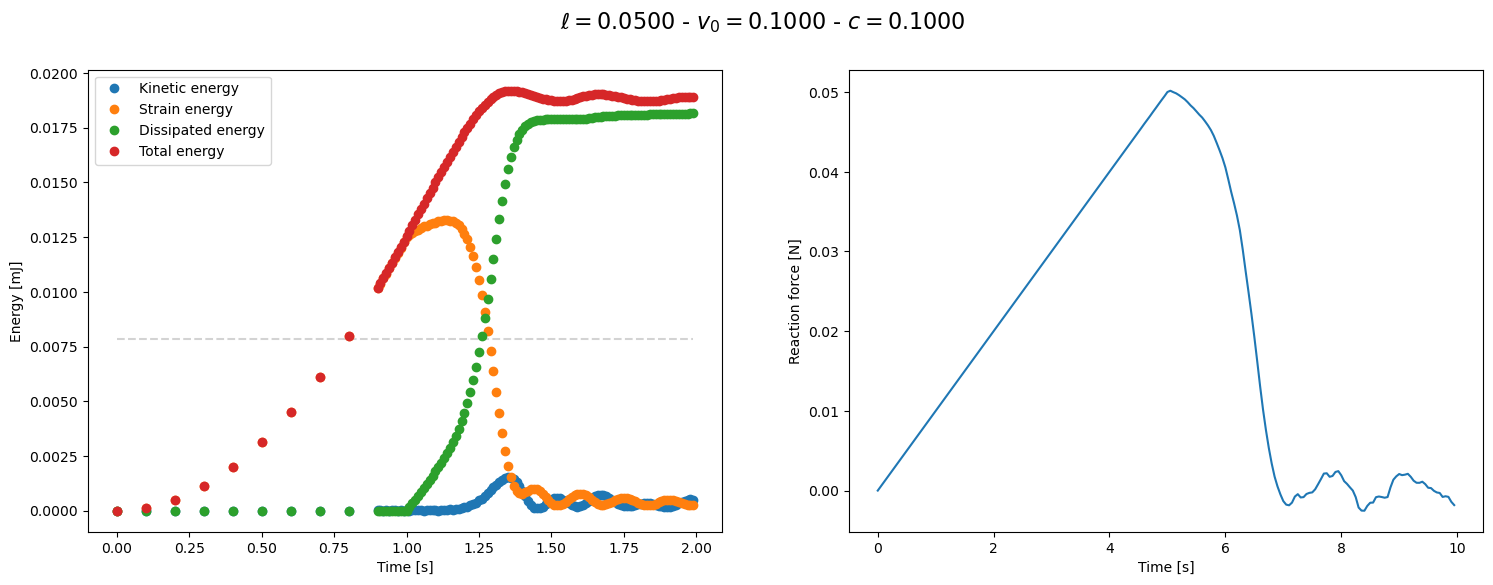

In [13]:
# Initialization
c_diss.value = 0.1
v_0 = 0.1
eps_c = sigma_c/E_0
kinetic_energies = []
elastic_energies = []
external_works = []
dissipated_energies = []
potential_energies =[]
reaction_force_right_s = []
ts = []
t.value = 0
i = 0

for func in [u,v,a,alpha,alpha_lb] :
    func.x.array[:] = 0.0

filename = f"fields-v0-{v_0:2.4}-ell-{ell.value:2.3}-c-{c_diss.value:2.4}"
with dolfinx.io.XDMFFile(comm,f'{outdir}/{filename}.xdmf','w') as xdmf_file:
    xdmf_file.write_mesh(mesh)
    #xdmf_file.write_function(u, t.value)
    #xdmf_file.write_function(alpha, t.value)

t_c = float(eps_c / v_0)
total_time = 2 * t_c

while t.value < total_time :
    if t.value < 0.85 * t_c :
        delta_t.value = t_c / 10.0
    else :
        delta_t.value = t_c / 100.0

    eps0_t.value = v_0 * t.value
    print(f"Solving for t = {t.value:3.2f}, load = {eps0_t.value:3.2f}, delta_t = {delta_t.value:2.4f}")

    alternate_minimization(state,parameters=alt_min_parameters,monitor=simple_monitor)
    u_new.x.array[:] = u_newmark(u.x.array, v.x.array, a.x.array, a_new.x.array,delta_t=float(delta_t))
    dolfinx.fem.set_bc(u_new.vector,bcs_u)
    u_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD) 
    v_new.x.array[:] = v_newmark(v.x.array, a.x.array, a_new.x.array, delta_t=float(delta_t))
    dolfinx.fem.set_bc(v_new.vector,bcs_v)
    v_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
     # Copy i+1 into i
    u.x.array[:] = u_new.x.array
    v.x.array[:] = v_new.x.array
    a.x.array[:] = a_new.x.array
    
    alpha_lb.x.array[:] = alpha.x.array
    solver_alpha_snes.setVariableBounds(alpha_lb.vector,alpha_ub.vector)

    kinetic_energies = np.concatenate((kinetic_energies,
                             [MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar(kinetic_energy_form), op=MPI.SUM)]))
    elastic_energies = np.concatenate((elastic_energies,
                            [MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar(elastic_energy_form), op=MPI.SUM)]))
    dissipated_energies = np.concatenate((dissipated_energies,
                            [MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar(dissipated_energy_form), op=MPI.SUM)]))
    potential_energies = np.concatenate((elastic_energies,
                            [MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar(potential_energy_form), op=MPI.SUM)]))
    reaction_force_right_s = np.concatenate((reaction_force_right_s,
                            [MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar(reaction_force_right_form), op=MPI.SUM)]))
    ts = np.concatenate((ts,[t.value]))
    
    with dolfinx.io.XDMFFile(comm,f'{outdir}/{filename}.xdmf','a') as xdmf_file:
        xdmf_file.write_function(u, t.value)        
        xdmf_file.write_function(alpha, t.value)
    
    
    # plot over line
    tol = 0.001 
    xs = np.linspace(-geometry_parameters['Lx']/2 + tol, geometry_parameters['Lx']/2 - tol, 101)
    points = np.zeros((3, 101))
    points[0, :] = xs
    points_loc, alpha_values_loc = evaluate_on_points(alpha,points)
    points_loc, u_values_loc = evaluate_on_points(u,points)
    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(points_loc[:, 0], alpha_values_loc[:,0], "k-", linewidth = 2, label=r"$\alpha$")
    plt.plot(points_loc[:, 0], u_values_loc[:,0]/max(u_values_loc[:,0]), "--", color="gray", linewidth = 2, label=r"$u$")
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel(r"$\alpha,\,u/u_{\mathrm{max}}$")
    plt.legend()
    plt.title(f"$t/t_c=${t.value/t_c} - $\ell=${ell.value:2.4f} - $v_0=${v_0:2.4f} - $c=${c_diss.value:2.4f}", fontsize=16)

    plt.savefig(f"{outdir}/{filename}-lineplot_{i}.png")
    plt.close()
    
    i += 1
    t.value += delta_t.value
        
fig2, ax2 = plt.subplots(1, 2, figsize=(18,6))
fig2.suptitle(f"$\ell=${ell.value:2.4f} - $v_0=${v_0:2.4f} - $c=${c_diss.value:2.4f}", fontsize=16)

ax2[0].plot(ts/t_c, Ly * float(G_c) * np.ones_like(ts), '--', color="lightgray")
ax2[0].plot(ts/t_c, kinetic_energies, 'o', label='Kinetic energy')
ax2[0].plot(ts/t_c, elastic_energies, 'o',label='Strain energy')
ax2[0].plot(ts/t_c, dissipated_energies, 'o', label='Dissipated energy')
ax2[0].plot(ts/t_c, kinetic_energies + elastic_energies + dissipated_energies, 'o', label='Total energy')
ax2[0].set_xlabel('Time [s]')
ax2[0].set_ylabel('Energy [mJ]')
ax2[0].legend()
ax2[1].plot (ts, reaction_force_right_s)
ax2[1].set_xlabel('Time [s]')
ax2[1].set_ylabel('Reaction force [N]')
plt.savefig(f'output/{filename}.png')

plot_damage_state(state, load=None)
frames = []
import imageio
import os
for ii in range(i):
    image = imageio.v2.imread(f'{outdir}/{filename}-lineplot_{ii}.png')
    os.remove(f'{outdir}/{filename}-lineplot_{ii}.png')
    frames.append(image)
imageio.mimsave(f'{outdir}/{filename}.gif', 
                frames, 
                loop = 1)
del frames